In [1]:
%load_ext autoreload
%autoreload 2

# Import libraries

In [2]:
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_store import nc_datasets, gc_datasets, lp_datasets
from model_store import model_names, stds
from explainer_store import explainer_names

In [ ]:
metrics = ['loss', 'accuracy', 'f1']
eval_metrics = ['iou', 'precision', 'recall', 'unfaithfulness', 'fid+', 'fid-', 'characterization_score', 'inference_time']
tasks = ['nc', 'gc', 'lp']

eval_metrics_path = 'eval_metrics/'
results_path = 'results/'
figures_path = 'figures/'
log_dir = 'logs/'


sns.set_style("whitegrid")
custom_palette = {explainer:color_hex for explainer, color_hex in zip(explainer_names, sns.color_palette("tab10", len(explainer_names)))}

std = stds[4]
runs = 10

In [4]:
def compute_mean_std(csv_files, output_file, save=False):
    """
    Reads multiple CSV files, computes the mean and standard deviation of each column,
    and prints the results in a formatted table.
    
    Parameters:
        csv_files (list): List of file paths to CSV files.
    """
    # Read all dataframes into a list
    dataframes = [pd.read_csv(file, header=[0, 1], index_col=[0, 1]) for file in csv_files]
    
    # Concatenate along a new axis to align indices and columns
    combined_data = pd.concat(dataframes, axis=0, keys=range(len(csv_files)), names=['Run'])
    
    # Compute mean and std
    mean_df = combined_data.groupby(level=[1, 2]).mean()
    std_df = combined_data.groupby(level=[1, 2]).std()
    
    # Create formatted results
    if save:
        formatted_results = mean_df.copy()
        for col in mean_df.columns:
            formatted_results[col] = mean_df[col].map(lambda x: f"{x:.4f}") + " ± " + std_df[col].map(lambda x: f"{x:.4f}")
        
        # Convert to tabulated format
        table_str = tabulate(formatted_results, headers='keys', tablefmt='grid')
        # Save to text file
        with open(output_file, "w") as f:
            f.write("Results Summary (Mean ± Std)\n\n")
            f.write(table_str)
        
        print(f"Results saved to {output_file}")
    
    return mean_df, std_df, combined_data

def overall_rank(df: pd.DataFrame, metrics=None) -> pd.DataFrame:
    # List of metric columns to process.
    if metrics is None:
        metrics = ['accuracy', 'iou', 'fid+', 'fid-', 'characterization_score']
    
    # Initialize a dictionary to hold cumulative points per explainer.
    scores = {explainer: 0 for explainer in df['Explainer'].unique()}
    
    # Count the total number of groups (Model x Dataset x Metric) for scaling.
    count_groups = 0

    # Create a copy of the input dataframe to hold the point values.
    df_points = df.copy()

    # Iterate over each combination of Model and Dataset.
    for model in df['Model'].unique():
        for dataset in df['Dataset'].unique():
            # Get the subset for this combination.
            mask = (df['Model'] == model) & (df['Dataset'] == dataset)
            subset = df_points.loc[mask, :]
            # Process each metric.
            for metric in metrics:
                count_groups += 1
                # For 'fid-' lower is better; for all other metrics, higher is better.
                ascending = True if metric == 'fid-' else False
                # Compute dense ranking for the metric in the current group.
                ranks = subset[metric].rank(method='dense', ascending=ascending)
                # Convert rank to points: best (rank 1) gets 4, rank 2 gets 3, etc.
                # Points = 4 - (rank - 1)
                points = 4 - (ranks - 1)
                # Update the metric column in df_points with the computed points.
                df_points.loc[mask, metric] = points
                # Also accumulate points for the overall score per explainer.
                for idx, rank in ranks.items():
                    pts = 4 - (rank - 1)
                    explainer = df_points.loc[idx, 'Explainer']
                    scores[explainer] += pts

    # Maximum possible points across all groups.
    max_points = 4 * count_groups
    # Scale the cumulative points to a 0 to 5 range.
    final_scores = {explainer: (points / max_points) * 5 for explainer, points in scores.items()}
    # Compute the average inference time for each explainer.
    avg_inference = df.groupby('Explainer')['inference_time'].mean().to_dict()
    
    # Build the final ranking dataframe.
    result_df = pd.DataFrame([
        {'Explainer': explainer, 'Score': score, 'Avg_Inference_Time': avg_inference.get(explainer, None)}
        for explainer, score in final_scores.items()
    ])
    result_df = result_df.sort_values(by='Score', ascending=False).reset_index(drop=True)
    
    # Return both dataframes.
    return result_df, df_points

In [5]:
def agg_std_test_metrics(model_metrics_df, stds):
    agg_data = {'model':[], 'std':[], 'test_loss':[], 'test_accuracy':[], 'test_f1':[], 'test_precision':[], 'test_recall':[]}
    for model_name, df_list in model_metrics_df.items():
        for std, df in zip(stds, df_list):    
            agg_data['model'].append(model_name)
            agg_data['std'].append(int(std)/10.0)
            agg_data['test_loss'].append(df.iloc[-1]["test_loss"])
            agg_data['test_accuracy'].append(df.iloc[-1]["test_accuracy"])
            agg_data['test_f1'].append(df.iloc[-1]["test_f1"])
            agg_data['test_precision'].append(df.iloc[-1]["test_precision"])
            agg_data['test_recall'].append(df.iloc[-1]["test_recall"])
    
    agg_df = pd.DataFrame(agg_data)
    return agg_df
        
    
def plot_metrics(figures_path, metrics, agg_metrics_df, dataset, task, save=False):
    if dataset in ['ba_community', 'tree_cycles']:
        agg_metrics_df = agg_metrics_df[agg_metrics_df['dataset'] == dataset]
        
    for metric in metrics:
        plt.figure(figsize=(8, 6))  # Create a new figure for each metric
        
        sns.lineplot(data=agg_metrics_df, x='std', y=f'test_{metric}', hue='model', linestyle="solid", errorbar=None)
    
        #plt.title(f"{metric.capitalize()}", fontsize=14)
        plt.xlabel("Standard Deviation")
        plt.xticks(agg_metrics_df['std'].unique())
        plt.ylabel(metric.capitalize())
        #plt.ylabel('')
        plt.legend()
        plt.tight_layout()
        if save:
            plt.savefig(f'{figures_path}{task}_{dataset}_{metric}.pdf', format='pdf')
        plt.show()  # Show each figure separately
        
def plot_test_xai_metrics(figures_path, xai_metrics, agg_xai_metrics_df, test_metrics, agg_test_metrics_df, dataset, task, save=False, color_palette=None):
    for test_metric in test_metrics:
        for xai_metric in xai_metrics:        
            # Create the base figure and primary axis
            fig, ax1 = plt.subplots(figsize=(8, 6))
            
            # Plot y1 using Seaborn on primary y-axis
            sns.lineplot(data=agg_test_metrics_df, x='std', y=f'test_{test_metric}', linestyle="--", color='blue', ax=ax1, label=f'test {test_metric}')
            ax1.set_ylabel(f'Test {test_metric.capitalize()}', color="blue")
            ax1.tick_params(axis='y', labelcolor='blue')
            
            
            # Customize x-axis ticks
            
            ax1.set_xticks(agg_xai_metrics_df['std'].unique())
            ax1.set_xticklabels(agg_xai_metrics_df['std'].unique())  # optional: custom label
            ax1.set_xlabel("Standard Deviation")
            
            # Create the secondary y-axis
            ax2 = ax1.twinx()
            
            # Plot y2 using Seaborn on secondary y-axis
            sns.lineplot(data=agg_xai_metrics_df, x='std', y=f'{xai_metric}', linestyle="-", hue='explainer', ax=ax2, errorbar="sd", palette=color_palette)
            
            # Add legends (optional)
            lines_1, labels_1 = ax1.get_legend_handles_labels()
            lines_2, labels_2 = ax2.get_legend_handles_labels()
            ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')
            ax2.legend_.remove()  # Safe way to remove if it exists
            plt.tight_layout()
            if save:
                plt.savefig(f'{figures_path}{task}_{dataset}_test_{test_metric}_{xai_metric}.pdf', format='pdf')
            plt.show()

# Node classification

In [95]:
task = tasks[0]
agg_dfs = []
for nc_dataset in nc_datasets[:2]:
    paths = {model:[f'{log_dir}/{task}_{model}_{nc_dataset}{std}/version_0/metrics.csv' for std in stds] for model in model_names}
    model_metrics= {model: [pd.read_csv(path) for path in paths] for model, paths in paths.items()}
    agg_dataset_df = agg_std_test_metrics(model_metrics, stds)
    agg_dataset_df['dataset'] = nc_dataset
    agg_dfs.append(agg_dataset_df)
agg_df = pd.concat(agg_dfs, axis=0).reset_index(drop=True)
#plot_metrics(figures_path, metrics, agg_df, 'all', task, save=False)

In [96]:
agg_test_metrics_df = agg_df.drop(columns=['model', 'dataset']).groupby(['std']).mean()[['test_loss', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall']].reset_index()
agg_test_metrics_df

,std,test_loss,test_accuracy,test_f1,test_precision,test_recall
0,0.0,0.080518,1.000000,1.000000,1.000000,1.000000
1,0.1,0.021011,0.998214,0.998160,0.998162,0.998264
2,0.2,0.108929,0.955357,0.928245,0.967124,0.934896
3,0.3,0.128496,0.943232,0.914028,0.940603,0.931858
4,0.4,0.207745,0.907287,0.863469,0.890708,0.884485
5,0.5,0.197988,0.930674,0.915624,0.917819,0.920632
6,0.6,0.283117,0.892396,0.851514,0.875539,0.863298
7,0.7,0.200086,0.916849,0.898073,0.905337,0.903441
8,0.8,0.373226,0.818174,0.732311,0.822951,0.768004
9,0.9,0.334927,0.855703,0.813549,0.854905,0.822830


In [8]:
eval_dfs = []
for std in stds:
    for explainer_name in explainer_names:
        filepath = f'{eval_metrics_path}{explainer_name}_nc_metrics_std_{std}.csv'
        eval_df = pd.read_csv(filepath)
        eval_dfs.append(eval_df)
eval_df = pd.concat(eval_dfs, axis=0).reset_index(drop=True)
eval_df['std'] = eval_df['std'].astype(int) / 10.0
eval_df

,explainer,dataset,model,std,accuracy,precision,recall,iou,fid+,fid-,unfaithfulness,characterization_score,inference_time,run
0,random_explainer,ba_shapes,gcn,0.0,0.531409,0.019048,0.019048,0.010582,0.571429,0.476190,0.618261,0.546584,0.000287,0
1,random_explainer,tree_grid,gcn,0.0,0.509206,0.006088,0.006088,0.003223,0.054795,0.027397,0.000000,0.103744,0.000284,0
2,random_explainer,ba_shapes,graphsage,0.0,0.511736,0.014286,0.014286,0.008598,0.380952,0.428571,0.445269,0.457143,0.000284,0
3,random_explainer,tree_grid,graphsage,0.0,0.483019,0.004566,0.004566,0.002417,0.136986,0.178082,0.000000,0.234834,0.000295,0
4,random_explainer,ba_shapes,gat,0.0,0.509069,0.000000,0.000000,0.000000,0.309524,0.500000,0.450418,0.382353,0.000283,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,ciexplainer,tree_grid,graphsage,1.0,0.925344,0.917808,0.917808,0.864107,0.000000,0.000000,0.000000,0.000000,0.023246,9
4396,ciexplainer,ba_shapes,gat,1.0,0.655463,0.657143,0.657143,0.556500,0.000000,0.000000,0.176205,0.000000,0.118519,9
4397,ciexplainer,tree_grid,gat,1.0,0.925344,0.917808,0.917808,0.856414,0.000000,0.000000,0.000000,0.000000,0.048879,9
4398,ciexplainer,ba_shapes,gin,1.0,0.655463,0.580952,0.580952,0.485261,0.000000,0.000000,0.369599,0.000000,0.054959,9


In [ ]:
#plot_test_xai_metrics(figures_path, eval_metrics, eval_df.drop(columns=['dataset', 'model']), metrics, agg_test_metrics_df, 'all', task, save=True, color_palette=custom_palette)

In [76]:
std = int(stds[4]) / 10.0
std

0.4

## BA-Shapes

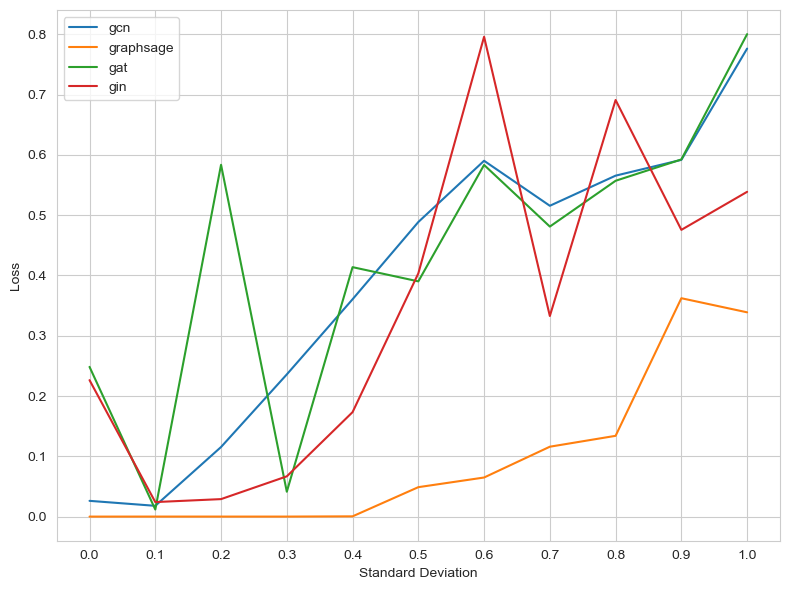

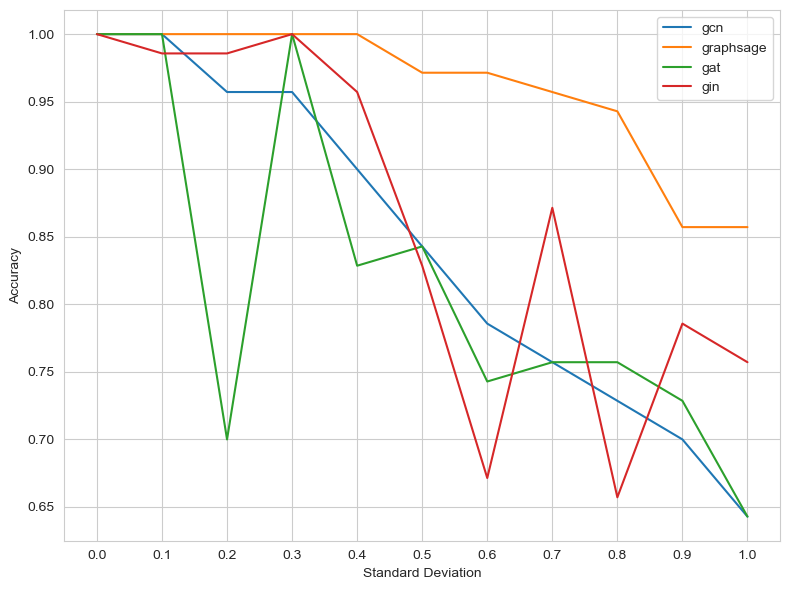

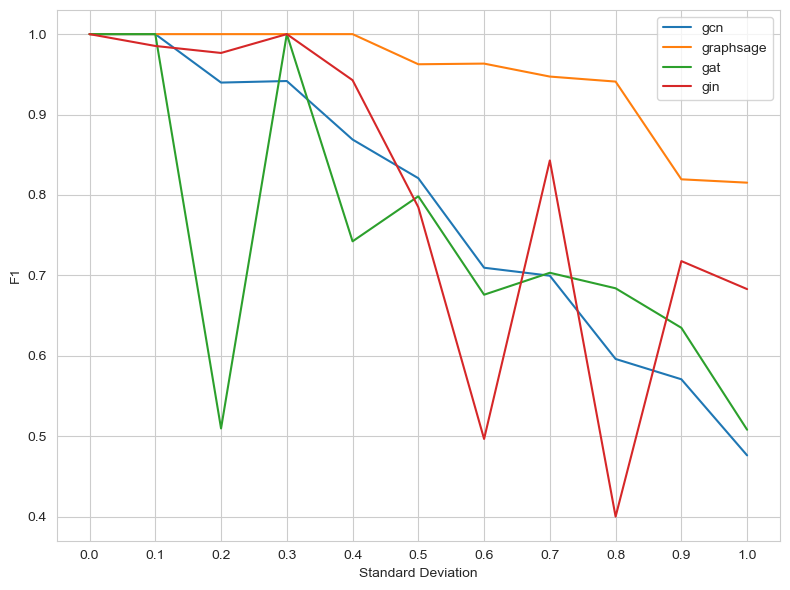

In [98]:
dataset = 'ba_shapes'
plot_metrics(figures_path, metrics, agg_df[agg_df['dataset'] == dataset], dataset, task, save=True)

In [77]:
agg_test_metrics_df = agg_df[agg_df['dataset'] == dataset].drop(columns=['model', 'dataset']).groupby(['std']).mean()[['test_loss', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall']].reset_index()
agg_test_metrics_df

,std,test_loss,test_accuracy,test_f1,test_precision,test_recall
0,0.0,0.125264,1.000000,1.000000,1.000000,1.000000
1,0.1,0.013476,0.996429,0.996320,0.996324,0.996528
2,0.2,0.182059,0.910714,0.856490,0.934248,0.869792
3,0.3,0.086026,0.989286,0.985417,0.984028,0.988715
4,0.4,0.237057,0.921429,0.888487,0.887571,0.898872
5,0.5,0.332837,0.871429,0.841615,0.847566,0.849826
6,0.6,0.508656,0.792857,0.711331,0.760693,0.733445
7,0.7,0.361400,0.835714,0.798222,0.813078,0.808594
8,0.8,0.486979,0.771429,0.655228,0.782581,0.693576
9,0.9,0.505591,0.767857,0.685679,0.765780,0.706163


In [12]:
dataset_eval_df = eval_df[eval_df['dataset'] == dataset]
#plot_test_xai_metrics(figures_path, eval_metrics, dataset_eval_df.drop(columns=['dataset', 'model']), metrics, agg_test_metrics_df, dataset, task, save=False, color_palette=custom_palette)
dataset_eval_df

In [ ]:
std = int(stds[4])/10.0
std

In [13]:
agg_xai_metrics_df = dataset_eval_df.drop(columns=['dataset']).groupby(['model', 'explainer', 'std']).agg(['mean', 'std'])[['iou', 'precision',  'inference_time']].reset_index()
agg_xai_metrics_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in agg_xai_metrics_df.columns]
std_xai_metrics_df = agg_xai_metrics_df[agg_xai_metrics_df['std'] == std]
std_xai_metrics_df

,model,explainer,std,iou_mean,iou_std,precision_mean,precision_std,inference_time_mean,inference_time_std
4,gat,ciexplainer,0.4,0.513776,0.043568,0.626190,0.038441,0.123833,0.001872
15,gat,gnnexplainer,0.4,0.462698,0.029302,0.608571,0.026542,1.804374,0.046060
26,gat,pgexplainer,0.4,0.600813,0.000000,0.638095,0.000000,0.003310,0.000043
37,gat,random_explainer,0.4,0.005357,0.004046,0.009524,0.007099,0.000277,0.000004
48,gat,subgraphx,0.4,0.427390,0.010000,0.583333,0.010589,17.778070,1.031850
59,gcn,ciexplainer,0.4,0.665552,0.042171,0.759048,0.035720,0.094280,0.000550
70,gcn,gnnexplainer,0.4,0.491969,0.019345,0.624286,0.018707,1.493202,0.024948
81,gcn,pgexplainer,0.4,0.600813,0.000000,0.638095,0.000000,0.002836,0.000034
92,gcn,random_explainer,0.4,0.002646,0.002160,0.004762,0.003888,0.000273,0.000004
103,gcn,subgraphx,0.4,0.396636,0.021330,0.548571,0.021034,16.198664,1.166205


In [19]:
model = model_names[3]
model_xai_metrics_df = std_xai_metrics_df[std_xai_metrics_df['model'] == model].drop(columns=['std'])
model_xai_metrics_df

,model,explainer,iou_mean,iou_std,precision_mean,precision_std,inference_time_mean,inference_time_std
114,gin,ciexplainer,0.490070,0.034875,0.597619,0.032549,0.058226,0.000544
125,gin,gnnexplainer,0.466327,0.024518,0.596190,0.025771,1.011916,0.033360
136,gin,pgexplainer,0.611489,0.011619,0.652381,0.013089,0.002288,0.000044
147,gin,random_explainer,0.003704,0.002556,0.006667,0.004600,0.000351,0.000002
158,gin,subgraphx,0.573942,0.012794,0.698571,0.011235,15.182417,0.591843


## Tree-Grid

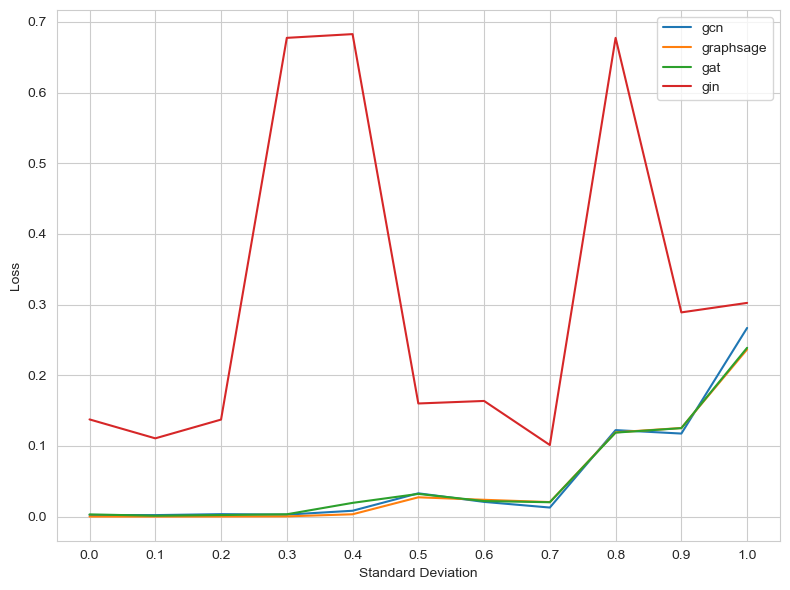

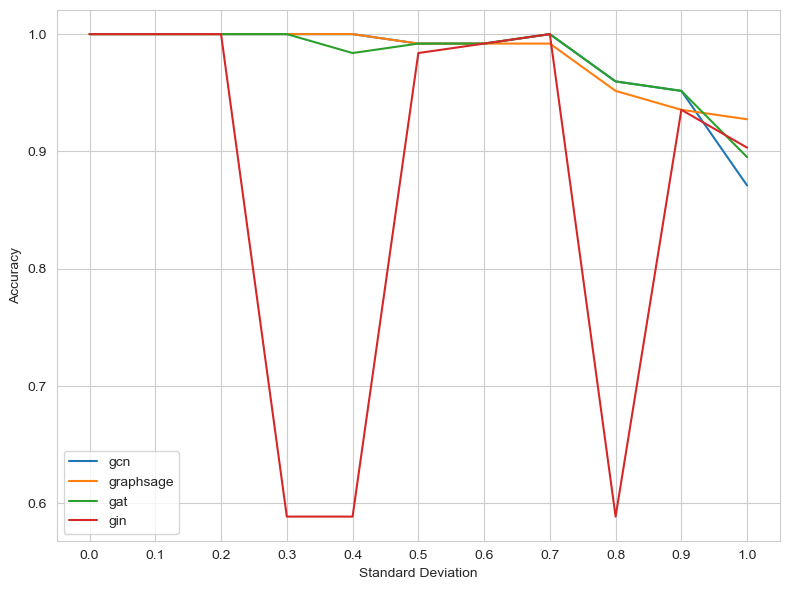

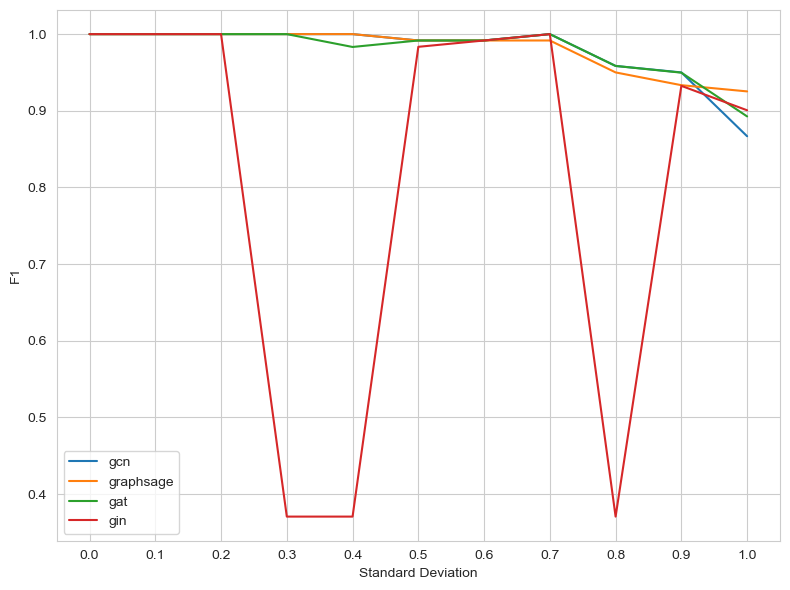

In [100]:
dataset = 'tree_grid'
plot_metrics(figures_path, metrics, agg_df[agg_df['dataset'] == dataset], dataset, task, save=True)

In [82]:
agg_test_metrics_df = agg_df[agg_df['dataset'] == dataset].drop(columns=['model', 'dataset']).groupby(['std']).mean()[['test_loss', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall']].reset_index()
agg_test_metrics_df

,std,test_loss,test_accuracy,test_f1,test_precision,test_recall
0,0.0,0.035771,1.000000,1.000000,1.000000,1.000000
1,0.1,0.028545,1.000000,1.000000,1.000000,1.000000
2,0.2,0.035798,1.000000,1.000000,1.000000,1.000000
3,0.3,0.170966,0.897177,0.842640,0.897177,0.875000
4,0.4,0.178433,0.893145,0.838450,0.893844,0.870098
5,0.5,0.063140,0.989919,0.989633,0.988071,0.991438
6,0.6,0.057578,0.991935,0.991697,0.990385,0.993151
7,0.7,0.038772,0.997984,0.997924,0.997596,0.998288
8,0.8,0.259474,0.864919,0.809393,0.863320,0.842432
9,0.9,0.164264,0.943548,0.941419,0.944029,0.939498


In [21]:
dataset_eval_df = eval_df[eval_df['dataset'] == dataset]
#plot_test_xai_metrics(figures_path, eval_metrics[:1], dataset_eval_df.drop(columns=['dataset', 'model']), metrics, agg_test_metrics_df, dataset, task, save=False, color_palette=custom_palette)
dataset_eval_df

,explainer,dataset,model,std,accuracy,precision,recall,iou,fid+,fid-,unfaithfulness,characterization_score,inference_time,run
1,random_explainer,tree_grid,gcn,0.0,0.509206,0.006088,0.006088,0.003223,0.054795,0.027397,0.0,0.103744,0.000284,0
3,random_explainer,tree_grid,graphsage,0.0,0.483019,0.004566,0.004566,0.002417,0.136986,0.178082,0.0,0.234834,0.000295,0
5,random_explainer,tree_grid,gat,0.0,0.488871,0.003044,0.003044,0.001712,0.136986,0.095890,0.0,0.237924,0.000285,0
7,random_explainer,tree_grid,gin,0.0,0.473215,0.009132,0.009132,0.004835,0.068493,0.068493,0.0,0.127604,0.000355,0
9,random_explainer,tree_grid,gcn,0.0,0.504189,0.013699,0.013699,0.007252,0.082192,0.013699,0.0,0.151739,0.000283,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4391,ciexplainer,tree_grid,gin,1.0,0.875824,0.864536,0.864536,0.811871,0.000000,0.000000,0.0,0.000000,0.023871,8
4393,ciexplainer,tree_grid,gcn,1.0,0.925344,0.923897,0.923897,0.870704,0.000000,0.000000,0.0,0.000000,0.037474,9
4395,ciexplainer,tree_grid,graphsage,1.0,0.925344,0.917808,0.917808,0.864107,0.000000,0.000000,0.0,0.000000,0.023246,9
4397,ciexplainer,tree_grid,gat,1.0,0.925344,0.917808,0.917808,0.856414,0.000000,0.000000,0.0,0.000000,0.048879,9


In [22]:
std = int(stds[4])/10.0
std

0.4

In [23]:
agg_xai_metrics_df = dataset_eval_df.drop(columns=['dataset']).groupby(['model', 'explainer', 'std']).agg(['mean', 'std'])[['iou', 'precision',  'inference_time']].reset_index()
agg_xai_metrics_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in agg_xai_metrics_df.columns]
std_xai_metrics_df = agg_xai_metrics_df[agg_xai_metrics_df['std'] == std]
std_xai_metrics_df

,model,explainer,std,iou_mean,iou_std,precision_mean,precision_std,inference_time_mean,inference_time_std
4,gat,ciexplainer,0.4,0.857181,0.013297,0.918113,0.009513,0.052265,0.000313
15,gat,gnnexplainer,0.4,0.798180,0.008662,0.881735,0.006048,1.812723,0.012226
26,gat,pgexplainer,0.4,0.759488,0.000000,0.834094,0.000000,0.003295,0.000041
37,gat,random_explainer,0.4,0.004210,0.001857,0.007915,0.003500,0.000278,0.000004
48,gat,subgraphx,0.4,0.306415,0.011056,0.456317,0.014525,0.257920,0.009142
59,gcn,ciexplainer,0.4,0.882690,0.003463,0.934551,0.002029,0.039938,0.000370
70,gcn,gnnexplainer,0.4,0.754556,0.009595,0.849467,0.006973,1.533052,0.019140
81,gcn,pgexplainer,0.4,0.759488,0.000000,0.834094,0.000000,0.002804,0.000036
92,gcn,random_explainer,0.4,0.004754,0.001675,0.008980,0.003164,0.000272,0.000003
103,gcn,subgraphx,0.4,0.312083,0.017565,0.463927,0.022958,0.230731,0.007816


In [27]:
model = model_names[3]
model_xai_metrics_df = std_xai_metrics_df[std_xai_metrics_df['model'] == model].drop(columns=['std'])
model_xai_metrics_df

,model,explainer,iou_mean,iou_std,precision_mean,precision_std,inference_time_mean,inference_time_std
114,gin,ciexplainer,0.018240,0.000000,0.022831,0.000000,0.025388,0.000138
125,gin,gnnexplainer,0.018240,0.000000,0.022831,0.000000,0.952180,0.017458
136,gin,pgexplainer,0.759488,0.000000,0.834094,0.000000,0.002305,0.000032
147,gin,random_explainer,0.003737,0.001861,0.007002,0.003456,0.000354,0.000003
158,gin,subgraphx,0.297886,0.011445,0.444901,0.015556,0.187125,0.003993


# Graph classification

In [83]:
task = tasks[1]
dataset = gc_datasets[0]
paths = {model:[f'{log_dir}/{task}_{model}_{dataset}{std}/version_0/metrics.csv' for std in stds] for model in model_names}
model_metrics= {model: [pd.read_csv(path) for path in paths] for model, paths in paths.items()}
agg_df = agg_std_test_metrics(model_metrics, stds)
#plot_metrics(figures_path, metrics, agg_df, dataset, task, save=False)

In [84]:
agg_test_metrics_df = agg_df.drop(columns=['model']).groupby(['std']).mean()[['test_loss', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall']].reset_index()
agg_test_metrics_df

,std,test_loss,test_accuracy,test_f1,test_precision,test_recall
0,0.0,1.189227e-07,1.000000,1.000000,1.000000,1.000000
1,0.1,8.023702e-09,1.000000,1.000000,1.000000,1.000000
2,0.2,1.203555e-08,1.000000,1.000000,1.000000,1.000000
3,0.3,1.335372e-07,1.000000,1.000000,1.000000,1.000000
4,0.4,4.640354e-05,1.000000,1.000000,1.000000,1.000000
5,0.5,1.133266e-04,1.000000,1.000000,1.000000,1.000000
6,0.6,1.768092e-01,0.987981,0.958242,0.961538,0.987981
7,0.7,9.281516e-02,0.956731,0.862637,0.875000,0.956731
8,0.8,2.187066e-01,0.923077,0.813807,0.836538,0.923077
9,0.9,4.353821e-02,0.985577,0.957509,0.961538,0.985577


In [30]:
eval_dfs = []
for std in stds:
    for explainer_name in explainer_names:
        filepath = f'{eval_metrics_path}{explainer_name}_gc_metrics_std_{std}.csv'
        eval_df = pd.read_csv(filepath)
        eval_dfs.append(eval_df)
eval_df = pd.concat(eval_dfs, axis=0).reset_index(drop=True)
eval_df['std'] = eval_df['std'].astype(int) / 10.0
eval_df

,explainer,dataset,model,std,accuracy,precision,recall,iou,fid+,fid-,unfaithfulness,characterization_score,inference_time,run
0,random_explainer,ba_2motif,gcn,0.0,0.5040,0.198,0.198,0.121190,0.0,0.00,0.0,0.0,0.000266,0
1,random_explainer,ba_2motif,graphsage,0.0,0.5112,0.216,0.216,0.133492,0.0,0.12,0.0,0.0,0.000267,0
2,random_explainer,ba_2motif,gat,0.0,0.5100,0.236,0.236,0.145833,0.0,0.42,0.0,0.0,0.000269,0
3,random_explainer,ba_2motif,gin,0.0,0.5148,0.194,0.194,0.117460,0.0,0.08,0.0,0.0,0.000337,0
4,random_explainer,ba_2motif,gcn,0.0,0.5092,0.196,0.196,0.116786,0.0,0.01,0.0,0.0,0.000265,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,ciexplainer,ba_2motif,gin,1.0,0.4000,0.300,0.300,0.246944,0.0,0.00,0.0,0.0,0.059997,8
2196,ciexplainer,ba_2motif,gcn,1.0,0.4000,0.330,0.330,0.270357,0.0,0.00,0.0,0.0,0.097183,9
2197,ciexplainer,ba_2motif,graphsage,1.0,0.4000,0.316,0.316,0.247579,0.0,0.00,0.0,0.0,0.058729,9
2198,ciexplainer,ba_2motif,gat,1.0,0.4000,0.362,0.362,0.306468,0.0,0.00,0.0,0.0,0.125218,9


In [31]:
#plot_test_xai_metrics(figures_path, eval_metrics, eval_df.drop(columns=['dataset', 'model']), metrics, agg_test_metrics_df, dataset, task, save=False, color_palette=custom_palette)

In [32]:
std = int(stds[4])/10.0
std

0.4

## BA-2motif

In [33]:
agg_xai_metrics_df = eval_df.drop(columns=['dataset']).groupby(['model', 'explainer', 'std']).agg(['mean', 'std'])[['iou', 'precision',  'inference_time']].reset_index()
agg_xai_metrics_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in agg_xai_metrics_df.columns]
std_xai_metrics_df = agg_xai_metrics_df[agg_xai_metrics_df['std'] == std]
std_xai_metrics_df

,model,explainer,std,iou_mean,iou_std,precision_mean,precision_std,inference_time_mean,inference_time_std
4,gat,ciexplainer,0.4,0.223234,0.030688,0.2752,0.033694,0.120747,0.000648
15,gat,gnnexplainer,0.4,0.104794,0.007026,0.1716,0.010617,1.793007,0.073128
26,gat,pgexplainer,0.4,0.324659,0.097074,0.4642,0.084808,0.002544,0.000009
37,gat,random_explainer,0.4,0.122401,0.008633,0.2020,0.012037,0.000266,0.000004
48,gat,subgraphx,0.4,0.305452,0.040227,0.3590,0.044234,1.046732,0.047847
59,gcn,ciexplainer,0.4,0.224528,0.080485,0.2914,0.107133,0.091797,0.000215
70,gcn,gnnexplainer,0.4,0.020917,0.006844,0.0362,0.011564,1.522664,0.031400
81,gcn,pgexplainer,0.4,0.209968,0.027067,0.3324,0.032779,0.002097,0.000007
92,gcn,random_explainer,0.4,0.121718,0.008069,0.2004,0.012322,0.000263,0.000004
103,gcn,subgraphx,0.4,0.298595,0.034041,0.3530,0.031301,0.956562,0.030700


In [37]:
model = model_names[3]
model_xai_metrics_df = std_xai_metrics_df[std_xai_metrics_df['model'] == model].drop(columns=['std'])
model_xai_metrics_df

,model,explainer,iou_mean,iou_std,precision_mean,precision_std,inference_time_mean,inference_time_std
114,gin,ciexplainer,0.249770,0.018673,0.3826,0.020484,0.056559,0.000172
125,gin,gnnexplainer,0.015524,0.004492,0.0266,0.006603,1.021805,0.050118
136,gin,pgexplainer,0.660365,0.104749,0.7604,0.082018,0.001543,0.000007
147,gin,random_explainer,0.121651,0.016328,0.1998,0.023785,0.000338,0.000002
158,gin,subgraphx,0.303821,0.022364,0.3594,0.022031,0.790365,0.029534


## MUTAG

In [87]:
mutag_eval_dfs = []
for explainer in explainer_names:
    mutag_path = f'{eval_metrics_path}{explainer}_gc_metrics_mutag.csv'
    mutag_df = pd.read_csv(mutag_path)
    mutag_eval_dfs.append(mutag_df)
mutag_eval_df = pd.concat(mutag_eval_dfs, axis=0).reset_index(drop=True)
mutag_eval_df

,explainer,dataset,model,std,accuracy,precision,recall,iou,fid+,fid-,unfaithfulness,characterization_score,inference_time,run,Unnamed: 0
0,random_explainer,mutag,gcn,NaN,0.498327,0.177015,0.177015,0.107187,0.343137,0.294118,0.0,0.461792,0.000256,0,NaN
1,random_explainer,mutag,graphsage,NaN,0.498619,0.166667,0.166667,0.107738,0.343137,0.803922,0.0,0.249554,0.000260,0,NaN
2,random_explainer,mutag,gat,NaN,0.511084,0.184368,0.184368,0.118184,0.245098,0.254902,0.0,0.368860,0.000257,0,NaN
3,random_explainer,mutag,gin,NaN,0.491698,0.173475,0.173475,0.110029,0.568627,0.843137,0.0,0.245893,0.000328,0,NaN
4,random_explainer,mutag,gcn,NaN,0.513373,0.165305,0.165305,0.104992,0.352941,0.254902,0.0,0.478992,0.000255,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ciexplainer,mutag,gin,NaN,0.422022,0.203431,0.203431,0.129869,0.000000,0.000000,0.0,0.000000,0.030570,8,NaN
196,ciexplainer,mutag,gcn,NaN,0.417820,0.245915,0.245915,0.164125,0.000000,0.009804,0.0,0.000000,0.049523,9,NaN
197,ciexplainer,mutag,graphsage,NaN,0.422022,0.254902,0.254902,0.164609,0.000000,0.000000,0.0,0.000000,0.030247,9,NaN
198,ciexplainer,mutag,gat,NaN,0.422022,0.147059,0.147059,0.089308,0.000000,0.000000,0.0,0.000000,0.065534,9,NaN


In [88]:
agg_xai_metrics_df = mutag_eval_df.drop(columns=['dataset', 'std']).groupby(['model', 'explainer']).agg(['mean', 'std'])[['iou', 'precision',  'inference_time']].reset_index()
agg_xai_metrics_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in agg_xai_metrics_df.columns]
agg_xai_metrics_df

,model,explainer,iou_mean,iou_std,precision_mean,precision_std,inference_time_mean,inference_time_std
0,gat,ciexplainer,0.094809,0.007097,0.154385,0.010955,0.064880,0.000560
1,gat,gnnexplainer,0.167785,0.016459,0.250654,0.021283,1.794057,0.061193
2,gat,pgexplainer,0.203484,0.033239,0.290251,0.037039,0.002510,0.000007
3,gat,random_explainer,0.107768,0.011310,0.169826,0.016214,0.000255,0.000002
4,gat,subgraphx,0.088374,0.013547,0.125436,0.016456,1.138724,0.054944
5,gcn,ciexplainer,0.152689,0.015727,0.228758,0.020251,0.049729,0.000279
6,gcn,gnnexplainer,0.622795,0.018884,0.723393,0.015112,1.517998,0.030463
7,gcn,pgexplainer,0.146192,0.033482,0.210920,0.046692,0.002059,0.000006
8,gcn,random_explainer,0.110774,0.008163,0.175409,0.012588,0.000252,0.000002
9,gcn,subgraphx,0.086577,0.015360,0.121351,0.017010,1.042847,0.060424


In [ ]:
model = model_names[3]
model_xai_metrics_df = agg_xai_metrics_df[agg_xai_metrics_df['model'] == model]
model_xai_metrics_df

# Link Prediction

In [89]:
task = tasks[2]
agg_dfs = []
for lp_dataset in lp_datasets[2:]:
    paths = {model:[f'{log_dir}/{task}_{model}_{lp_dataset}{std}/version_0/metrics.csv' for std in stds] for model in model_names}
    model_metrics= {model: [pd.read_csv(path) for path in paths] for model, paths in paths.items()}
    agg_dataset_df = agg_std_test_metrics(model_metrics, stds)
    agg_dataset_df['dataset'] = lp_dataset
    agg_dfs.append(agg_dataset_df)
agg_df = pd.concat(agg_dfs, axis=0).reset_index(drop=True)
#plot_metrics(figures_path, metrics, agg_df, 'all', task, save=False)

In [90]:
agg_test_metrics_df = agg_df.drop(columns=['model', 'dataset']).groupby(['std']).mean()[['test_loss', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall']].reset_index()
agg_test_metrics_df

,std,test_loss,test_accuracy,test_f1,test_precision,test_recall
0,0.0,0.619565,0.738815,0.725622,0.795423,0.738815
1,0.1,0.607754,0.774345,0.765253,0.822224,0.774345
2,0.2,0.615802,0.756420,0.744754,0.812546,0.756420
3,0.3,0.615669,0.764198,0.753019,0.821024,0.764198
4,0.4,0.595456,0.776001,0.766282,0.830049,0.776001
5,0.5,0.596967,0.756246,0.742820,0.820105,0.756246
6,0.6,0.587595,0.758582,0.745067,0.822127,0.758582
7,0.7,0.600058,0.765582,0.753664,0.827463,0.765582
8,0.8,0.597950,0.758363,0.745066,0.823862,0.758363
9,0.9,0.580116,0.774640,0.763692,0.834870,0.774640


In [40]:
eval_dfs = []
exps = ['random_explainer', 'gnnexplainer', 'pgexplainer', 'ciexplainer']
for std in stds:
    for explainer_name in exps:
        filepath = f'{eval_metrics_path}{explainer_name}_lp_metrics_std_{std}.csv'
        eval_df = pd.read_csv(filepath)
        eval_dfs.append(eval_df)
eval_df = pd.concat(eval_dfs, axis=0).reset_index(drop=True)
eval_df['std'] = eval_df['std'].astype(int) / 10.0
eval_df

,explainer,dataset,model,std,accuracy,precision,recall,iou,fid+,fid-,unfaithfulness,characterization_score,inference_time,run
0,random_explainer,ba_shapes_link,gcn,0.0,1.0,0.010169,0.010169,0.005650,0.050847,0.084746,0.0,0.096343,0.000263,0
1,random_explainer,tree_grid_link,gcn,0.0,1.0,0.001277,0.001277,0.000676,0.034483,0.034483,0.0,0.066587,0.000256,0
2,random_explainer,ba_shapes_link,graphsage,0.0,1.0,0.006780,0.006780,0.003766,0.084746,0.067797,0.0,0.155367,0.000265,0
3,random_explainer,tree_grid_link,graphsage,0.0,1.0,0.007663,0.007663,0.004057,0.011494,0.022989,0.0,0.022721,0.000262,0
4,random_explainer,ba_shapes_link,gat,0.0,1.0,0.010169,0.010169,0.005650,0.237288,0.203390,0.0,0.365657,0.000257,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3515,ciexplainer,tree_grid_link,graphsage,1.0,0.0,0.006386,0.006386,0.003381,0.000000,0.000000,0.0,0.000000,0.001509,9
3516,ciexplainer,ba_shapes_link,gat,1.0,0.0,0.016949,0.016949,0.013183,0.000000,0.000000,0.0,0.000000,0.001636,9
3517,ciexplainer,tree_grid_link,gat,1.0,0.0,0.006386,0.006386,0.003381,0.000000,0.000000,0.0,0.000000,0.001513,9
3518,ciexplainer,ba_shapes_link,gin,1.0,0.0,0.016949,0.016949,0.013183,0.000000,0.000000,0.0,0.000000,0.001668,9


In [41]:
#plot_test_xai_metrics(figures_path, eval_metrics, eval_df.drop(columns=['dataset', 'model']), metrics, agg_test_metrics_df, 'all', task, save=False, color_palette=custom_palette)

In [91]:
std = int(stds[4])/10.0
std

0.4

## BA-Shapes-Link

In [92]:
dataset = 'ba_shapes_link'
agg_test_metrics_df = agg_df[agg_df['dataset'] == dataset].drop(columns=['model', 'dataset']).groupby(['std']).mean()[['test_loss', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall']].reset_index()
agg_test_metrics_df

,std,test_loss,test_accuracy,test_f1,test_precision,test_recall
0,0.0,0.597438,0.726829,0.713820,0.777754,0.726829
1,0.1,0.590958,0.778659,0.770987,0.821421,0.778659
2,0.2,0.603598,0.765244,0.756658,0.809011,0.765244
3,0.3,0.605109,0.774390,0.765615,0.822299,0.774390
4,0.4,0.583771,0.785976,0.778105,0.833154,0.785976
5,0.5,0.587970,0.768902,0.758206,0.824602,0.768902
6,0.6,0.577047,0.787195,0.778908,0.837781,0.787195
7,0.7,0.601004,0.757927,0.745055,0.822824,0.757927
8,0.8,0.585149,0.770732,0.760120,0.828517,0.770732
9,0.9,0.571349,0.764024,0.751951,0.825447,0.764024


In [94]:
agg_df[(agg_df['dataset'] == 'tree_grid_link')&(agg_df['std'] == std)].drop(columns=['std'])[['model', 'test_loss', 'test_accuracy', 'test_f1',]]

,model,test_loss,test_accuracy,test_f1
48,gcn,0.611797,0.772436,0.761434
59,graphsage,0.616286,0.746795,0.732131
70,gat,0.622301,0.762821,0.749479
81,gin,0.578177,0.782051,0.774796


In [44]:
dataset_eval_df = eval_df[eval_df['dataset'] == dataset]
#plot_test_xai_metrics(figures_path, eval_metrics, dataset_eval_df.drop(columns=['dataset', 'model']), metrics, agg_test_metrics_df, dataset, task, save=True, color_palette=custom_palette)
dataset_eval_df

,explainer,dataset,model,std,accuracy,precision,recall,iou,fid+,fid-,unfaithfulness,characterization_score,inference_time,run
0,random_explainer,ba_shapes_link,gcn,0.0,1.0,0.010169,0.010169,0.005650,0.050847,0.084746,0.0,0.096343,0.000263,0
2,random_explainer,ba_shapes_link,graphsage,0.0,1.0,0.006780,0.006780,0.003766,0.084746,0.067797,0.0,0.155367,0.000265,0
4,random_explainer,ba_shapes_link,gat,0.0,1.0,0.010169,0.010169,0.005650,0.237288,0.203390,0.0,0.365657,0.000257,0
6,random_explainer,ba_shapes_link,gin,0.0,1.0,0.000000,0.000000,0.000000,0.169492,0.135593,0.0,0.283412,0.000308,0
8,random_explainer,ba_shapes_link,gcn,0.0,1.0,0.003390,0.003390,0.001883,0.101695,0.118644,0.0,0.182350,0.000258,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3510,ciexplainer,ba_shapes_link,gin,1.0,0.0,0.016949,0.016949,0.013183,0.000000,0.000000,0.0,0.000000,0.001663,8
3512,ciexplainer,ba_shapes_link,gcn,1.0,0.0,0.016949,0.016949,0.013183,0.000000,0.000000,0.0,0.000000,0.001623,9
3514,ciexplainer,ba_shapes_link,graphsage,1.0,0.0,0.016949,0.016949,0.013183,0.000000,0.000000,0.0,0.000000,0.001631,9
3516,ciexplainer,ba_shapes_link,gat,1.0,0.0,0.016949,0.016949,0.013183,0.000000,0.000000,0.0,0.000000,0.001636,9


In [45]:
std = int(stds[4])/10.0
std

0.4

In [46]:
agg_xai_metrics_df = dataset_eval_df.drop(columns=['dataset']).groupby(['model', 'explainer', 'std']).agg(['mean', 'std'])[['iou', 'precision',  'inference_time']].reset_index()
agg_xai_metrics_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in agg_xai_metrics_df.columns]
std_xai_metrics_df = agg_xai_metrics_df[agg_xai_metrics_df['std'] == std]
std_xai_metrics_df

,model,explainer,std,iou_mean,iou_std,precision_mean,precision_std,inference_time_mean,inference_time_std
4,gat,ciexplainer,0.4,0.013183,0.000000,0.016949,0.000000,0.001645,0.000013
15,gat,gnnexplainer,0.4,0.430798,0.015008,0.545763,0.017650,1.436524,0.040187
26,gat,pgexplainer,0.4,0.559188,0.000000,0.600000,0.000000,0.002649,0.000025
37,gat,random_explainer,0.4,0.003013,0.002693,0.005424,0.004847,0.000257,0.000003
48,gcn,ciexplainer,0.4,0.013183,0.000000,0.016949,0.000000,0.001637,0.000009
59,gcn,gnnexplainer,0.4,0.478982,0.022963,0.605085,0.023823,1.214626,0.019956
70,gcn,pgexplainer,0.4,0.559188,0.000000,0.600000,0.000000,0.002309,0.000019
81,gcn,random_explainer,0.4,0.003625,0.001088,0.006441,0.001924,0.000252,0.000004
92,gin,ciexplainer,0.4,0.013183,0.000000,0.016949,0.000000,0.001674,0.000008
103,gin,gnnexplainer,0.4,0.528814,0.022653,0.647458,0.020213,0.916944,0.026803


In [51]:
model = model_names[3]
model_xai_metrics_df = std_xai_metrics_df[std_xai_metrics_df['model'] == model].drop(columns=['std'])
model_xai_metrics_df

,model,explainer,iou_mean,iou_std,precision_mean,precision_std,inference_time_mean,inference_time_std
92,gin,ciexplainer,0.013183,0.000000,0.016949,0.000000,0.001674,0.000008
103,gin,gnnexplainer,0.528814,0.022653,0.647458,0.020213,0.916944,0.026803
114,gin,pgexplainer,0.559188,0.000000,0.600000,0.000000,0.001981,0.000020
125,gin,random_explainer,0.002448,0.002184,0.004407,0.003931,0.000311,0.000006


## Tree-Grid-Link

In [66]:
dataset = 'tree_grid_link'
agg_test_metrics_df = agg_df[agg_df['dataset'] == dataset].drop(columns=['model', 'dataset']).groupby(['std']).mean()[['test_loss', 'test_accuracy', 'test_f1', 'test_precision', 'test_recall']].reset_index()
agg_test_metrics_df

,std,test_loss,test_accuracy,test_f1,test_precision,test_recall
0,0.0,0.641692,0.750801,0.737423,0.813091,0.750801
1,0.1,0.624550,0.770032,0.759519,0.823028,0.770032
2,0.2,0.628007,0.747596,0.732850,0.816081,0.747596
3,0.3,0.626229,0.754006,0.740422,0.819749,0.754006
4,0.4,0.607140,0.766026,0.754460,0.826944,0.766026
5,0.5,0.605964,0.743590,0.727433,0.815608,0.743590
6,0.6,0.598143,0.729968,0.711226,0.806472,0.729968
7,0.7,0.599113,0.773237,0.762272,0.832101,0.773237
8,0.8,0.610752,0.745994,0.730013,0.819207,0.745994
9,0.9,0.588884,0.785256,0.775432,0.844292,0.785256


In [67]:
dataset_eval_df = eval_df[eval_df['dataset'] == dataset]
#plot_test_xai_metrics(figures_path, eval_metrics, dataset_eval_df.drop(columns=['dataset', 'model']), metrics, agg_test_metrics_df, dataset, task, save=False)
dataset_eval_df

,explainer,dataset,model,std,accuracy,precision,recall,iou,fid+,fid-,unfaithfulness,characterization_score,inference_time,run
1,random_explainer,tree_grid_link,gcn,0.0,1.0,0.001277,0.001277,0.000676,0.034483,0.034483,0.0,0.066587,0.000256,0
3,random_explainer,tree_grid_link,graphsage,0.0,1.0,0.007663,0.007663,0.004057,0.011494,0.022989,0.0,0.022721,0.000262,0
5,random_explainer,tree_grid_link,gat,0.0,1.0,0.012771,0.012771,0.006761,0.126437,0.183908,0.0,0.218951,0.000258,0
7,random_explainer,tree_grid_link,gin,0.0,1.0,0.007663,0.007663,0.004057,0.000000,0.011494,0.0,0.000000,0.000308,0
9,random_explainer,tree_grid_link,gcn,0.0,1.0,0.002554,0.002554,0.001352,0.034483,0.022989,0.0,0.066614,0.000258,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3511,ciexplainer,tree_grid_link,gin,1.0,0.0,0.006386,0.006386,0.003381,0.000000,0.000000,0.0,0.000000,0.001565,8
3513,ciexplainer,tree_grid_link,gcn,1.0,0.0,0.006386,0.006386,0.003381,0.000000,0.000000,0.0,0.000000,0.001509,9
3515,ciexplainer,tree_grid_link,graphsage,1.0,0.0,0.006386,0.006386,0.003381,0.000000,0.000000,0.0,0.000000,0.001509,9
3517,ciexplainer,tree_grid_link,gat,1.0,0.0,0.006386,0.006386,0.003381,0.000000,0.000000,0.0,0.000000,0.001513,9


In [68]:
std = int(stds[4])/10.0
std

0.4

In [69]:
agg_xai_metrics_df = dataset_eval_df.drop(columns=['dataset']).groupby(['model', 'explainer', 'std']).agg(['mean', 'std'])[['iou', 'precision',  'inference_time']].reset_index()
agg_xai_metrics_df.columns = [f'{col[0]}_{col[1]}' if col[1] else col[0] for col in agg_xai_metrics_df.columns]
std_xai_metrics_df = agg_xai_metrics_df[agg_xai_metrics_df['std'] == std]
std_xai_metrics_df

,model,explainer,std,iou_mean,iou_std,precision_mean,precision_std,inference_time_mean,inference_time_std
4,gat,ciexplainer,0.4,0.003381,0.000000,0.006386,0.000000,0.001525,0.000006
15,gat,gnnexplainer,0.4,0.762689,0.004346,0.856322,0.003143,1.439023,0.033110
26,gat,pgexplainer,0.4,0.762050,0.000000,0.850575,0.000000,0.002652,0.000029
37,gat,random_explainer,0.4,0.003998,0.001858,0.007535,0.003482,0.000257,0.000002
48,gcn,ciexplainer,0.4,0.003381,0.000000,0.006386,0.000000,0.001515,0.000004
59,gcn,gnnexplainer,0.4,0.772246,0.004408,0.862324,0.002746,1.219195,0.021632
70,gcn,pgexplainer,0.4,0.762050,0.000000,0.850575,0.000000,0.002309,0.000014
81,gcn,random_explainer,0.4,0.003651,0.001568,0.006897,0.002962,0.000255,0.000008
92,gin,ciexplainer,0.4,0.003381,0.000000,0.006386,0.000000,0.001556,0.000008
103,gin,gnnexplainer,0.4,0.768664,0.003692,0.859131,0.002952,0.922229,0.026190


In [73]:
model = model_names[3]
model_xai_metrics_df = std_xai_metrics_df[std_xai_metrics_df['model'] == model].drop(columns=['std'])
model_xai_metrics_df

,model,explainer,iou_mean,iou_std,precision_mean,precision_std,inference_time_mean,inference_time_std
92,gin,ciexplainer,0.003381,0.000000,0.006386,0.000000,0.001556,0.000008
103,gin,gnnexplainer,0.768664,0.003692,0.859131,0.002952,0.922229,0.026190
114,gin,pgexplainer,0.762050,0.000000,0.850575,0.000000,0.001975,0.000031
125,gin,random_explainer,0.003727,0.001331,0.007024,0.002500,0.000312,0.000003
